In [1]:
# Imports
%load_ext autoreload
%aimport sym
%autoreload 1
import os 
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sym import LCN, ProgressBar, Classification_report, Logger
from sym.utils import utils
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use('dark_background')

In [2]:
testset = torch.load("./data/testset_rand.pt")
trainset = torch.load("./data/trainset_rand.pt")
trainset, valset = torch.utils.data.random_split(trainset,[55000,5000])
trainloader = torch.utils.data.DataLoader(trainset, num_workers=6, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, num_workers=6)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=6)
del testset, trainset, valset

Text(0.5, 0.91, 'Validation Data')

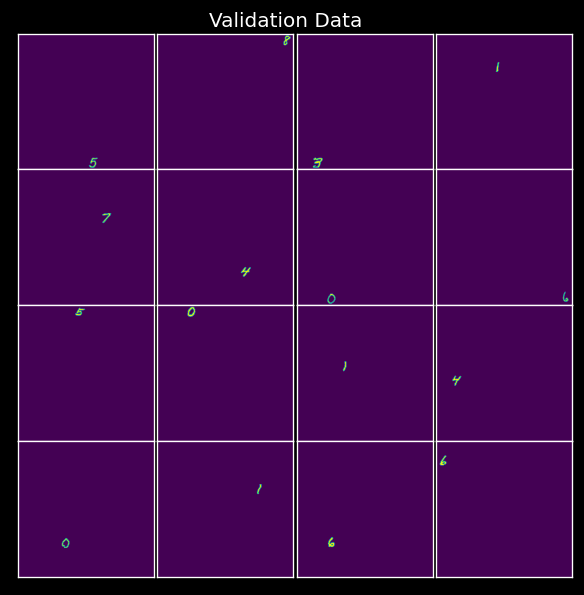

In [3]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
x,y = next(iter(trainloader))
for img,label, ax in zip(x,y,axes.flatten()):
    ax.imshow(img.squeeze().numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Validation Data", y=.91)

In [4]:
logdir = "./lightning_logs/MNIST/RAND/Adam/"
if not os.path.exists(logdir): os.makedirs(logdir,exist_ok=True)
epochs = 10
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
epochs = 10
lr = 1e-6
weight_decay=1e-3
optim = torch.optim.Adam
params = {"in_channels":1,"out_channels":10,"h":280,"w":280,"nfilters":256,"hidden":64,"kernel_size":28,
          "stride":28,"readout_activation":None}

In [5]:
# Train the CNN 
module = sym.models.CNN(**params)
cnn = sym.models.Model(module,zeroparams=1e-5,
    optim=optim(module.parameters(),lr=lr))

In [6]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="CNN",default_hp_metric=False)
path = logdir+f"CNN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(cnn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/RAND/Adam/CNN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 1.8 M 


Epoch 9: 100%|##########| 1876/1876 [00:22<00:00, 84.69it/s, loss=0.013, v_num=0, val_loss=0.0138, val_acc=0.927, zero_params=1337]


1

# LCN 

In [7]:
# Train the LCN 
module = sym.models.LCN(**params)
lcn = sym.models.Model(module,zeroparams=1e-5,
    optim=optim(module.parameters(),lr=lr,weight_decay=weight_decay))

In [8]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="LCN",default_hp_metric=False)
path = logdir+f"LCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(lcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/RAND/Adam/LCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LCN  | 21.7 M


Epoch 9: 100%|##########| 1876/1876 [01:26<00:00, 21.59it/s, loss=0.088, v_num=0, val_loss=0.088, val_acc=0.148, zero_params=1.69e+7] 


1

# FCN 

In [9]:
# Train the FCN 
module = sym.models.FCN(**params)
fcn = sym.models.Model(module,zeroparams=1e-5,
    optim=optim(module.parameters(),lr=lr,weight_decay=weight_decay))

In [10]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="FCN",default_hp_metric=False)
path = logdir+f"FCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(fcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/RAND/Adam/FCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 20.1 M


Epoch 9: 100%|##########| 1876/1876 [00:24<00:00, 75.61it/s, loss=0.070, v_num=0, val_loss=0.0733, val_acc=0.397, zero_params=1.1e+7] 


1

Text(0.5, 0.91, 'CNN Filters')

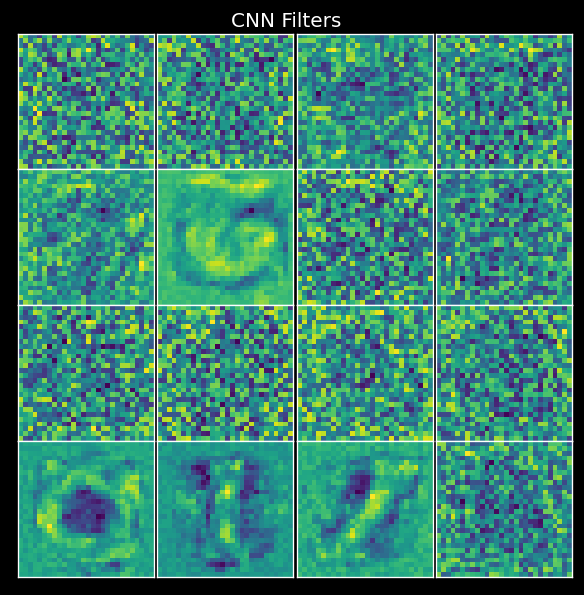

In [11]:
weights_cnn = next(cnn.model.parameters()).detach().cpu().squeeze()
filters_cnn = utils.minmaxnorm(weights_cnn)
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn,axes.flatten()):
    ax.imshow(img.numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("CNN Filters", y=.91)

In [12]:
weights_fcn = next(fcn.model.parameters()).detach().cpu()
filters_fcn = utils.minmaxnorm(weights_fcn)

Text(0.5, 0.91, 'FCN Filters')

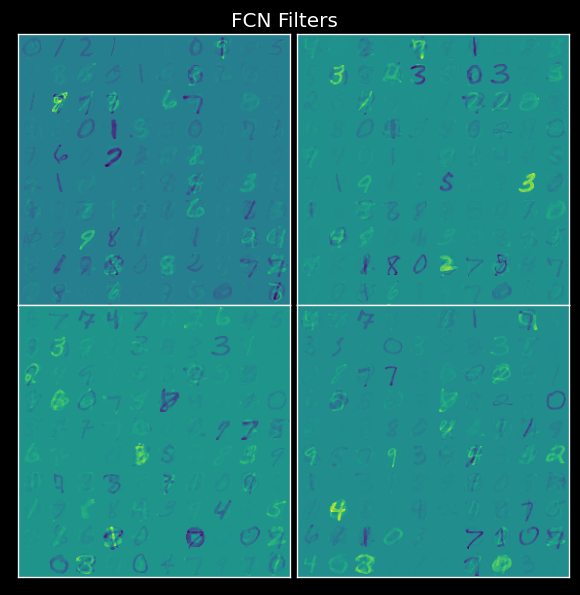

In [13]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[100:],axes.flatten()):
    ax.imshow(img.view(280,280).numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("FCN Filters", y=.91)

In [14]:
weights_lcn = next(lcn.model.parameters()).detach().cpu().squeeze()
weights_lcn = weights_lcn.unflatten(0,(nfilters,10,10)) #get filter locations
weights_lcn = weights_lcn.permute(0,1,3,2,4) # height and width next to each other
weights_lcn = weights_lcn.flatten(1,2).flatten(2,3)

Text(0.5, 0.91, 'LCN Filters')

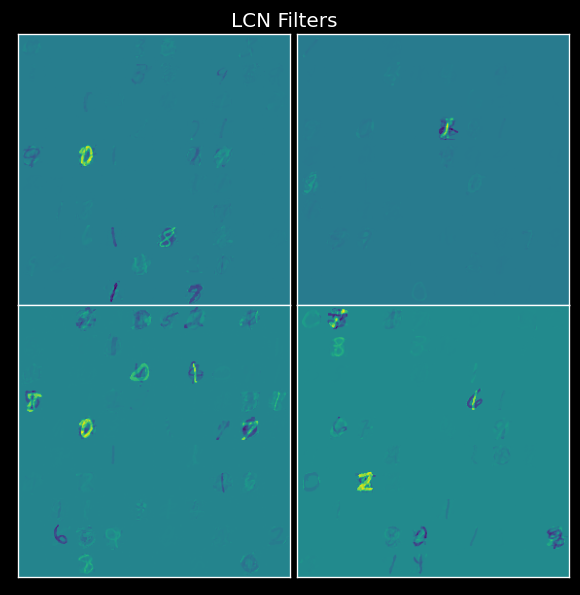

In [15]:
filters_lcn = utils.minmaxnorm(weights_lcn)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[200:],axes.flatten()):
    ax.imshow(img.numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("LCN Filters", y=.91)

In [16]:
# Loading a model
# module2 = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
#                      kernel_size=kernel_size, stride=stride, readout_activation=None)
# fcn2 = sym.models.Model(module,
#     optim=torch.optim.Adam(module.parameters(),lr=1e-6,weight_decay=1e-3))
# fcn2.load_from_checkpoint("lightning_logs/MNIST/FCN/version_0/weights.cpkt-v0.ckpt", model = module2)

# Testing 

In [17]:
testset_rand = torch.load("./data/testset_rand.pt")
testloader_rand = torch.utils.data.DataLoader(testset_rand, batch_size=32, num_workers=6)
del testset_rand

In [18]:
trainer = pl.Trainer(callbacks=[bar],gpus=0)
cnn_tests = [trainer.test(cnn,testloader)]
lcn_tests = [trainer.test(lcn,testloader)]
fcn_tests = [trainer.test(fcn,testloader)]
cnn_tests.append(trainer.test(cnn,testloader_rand))
lcn_tests.append(trainer.test(lcn,testloader_rand))
fcn_tests.append(trainer.test(fcn,testloader_rand))
fcn_acc_diag = np.mean([x["val_acc"] for x in fcn_tests[0]])
fcn_acc_rand = np.mean([x["val_acc"] for x in fcn_tests[1]])
cnn_acc_diag = np.mean([x["val_acc"] for x in cnn_tests[0]])
cnn_acc_rand = np.mean([x["val_acc"] for x in cnn_tests[1]])
lcn_acc_diag = np.mean([x["val_acc"] for x in lcn_tests[0]])
lcn_acc_rand = np.mean([x["val_acc"] for x in lcn_tests[1]])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Testing: 0it [00:00, ?it/s]

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Testing:  98%|#########7| 306/313 [00:04<00:00, 79.75it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': tensor(0.9302), 'val_loss': tensor(0.0128)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'val_acc': tensor(1.), 'val_loss': tensor(0.0012)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'val_acc': tensor(0.9375), 'val_loss': tensor(0.0122)}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'val_acc': tensor(0.9688), 'val_loss': tensor(0.0063)}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'val_acc': tensor(0.9688), 'val_loss': tensor(0.0034)}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'val_acc': tensor(0.937

--------------------------------------------------------------------------------
DATALOADER:229 TEST RESULTS
{'val_acc': tensor(0.9375), 'val_loss': tensor(0.0132)}
--------------------------------------------------------------------------------
DATALOADER:230 TEST RESULTS
{'val_acc': tensor(0.9375), 'val_loss': tensor(0.0108)}
--------------------------------------------------------------------------------
DATALOADER:231 TEST RESULTS
{'val_acc': tensor(0.9375), 'val_loss': tensor(0.0127)}
--------------------------------------------------------------------------------
DATALOADER:232 TEST RESULTS
{'val_acc': tensor(0.9688), 'val_loss': tensor(0.0030)}
--------------------------------------------------------------------------------
DATALOADER:233 TEST RESULTS
{'val_acc': tensor(0.8750), 'val_loss': tensor(0.0227)}
--------------------------------------------------------------------------------
DATALOADER:234 TEST RESULTS
{'val_acc': tensor(0.9688), 'val_loss': tensor(0.0057)}
----------

Testing: 100%|##########| 313/313 [03:17<00:00,  1.70it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': tensor(0.1532), 'val_loss': tensor(0.0876)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'val_acc': tensor(0.2500), 'val_loss': tensor(0.0821)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'val_acc': tensor(0.1562), 'val_loss': tensor(0.0883)}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'val_acc': tensor(0.1875), 'val_loss': tensor(0.0868)}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'val_acc': tensor(0.1250), 'val_loss': tensor(0.0907)}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'val_acc': tensor(0

{'val_acc': tensor(0.2500), 'val_loss': tensor(0.0829)}
--------------------------------------------------------------------------------
DATALOADER:251 TEST RESULTS
{'val_acc': tensor(0.1250), 'val_loss': tensor(0.0903)}
--------------------------------------------------------------------------------
DATALOADER:252 TEST RESULTS
{'val_acc': tensor(0.1875), 'val_loss': tensor(0.0906)}
--------------------------------------------------------------------------------
DATALOADER:253 TEST RESULTS
{'val_acc': tensor(0.1562), 'val_loss': tensor(0.0859)}
--------------------------------------------------------------------------------
DATALOADER:254 TEST RESULTS
{'val_acc': tensor(0.2188), 'val_loss': tensor(0.0888)}
--------------------------------------------------------------------------------
DATALOADER:255 TEST RESULTS
{'val_acc': tensor(0.1250), 'val_loss': tensor(0.0856)}
--------------------------------------------------------------------------------
DATALOADER:256 TEST RESULTS
{'val_acc'

Testing:  98%|#########8| 307/313 [00:04<00:00, 85.12it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': tensor(0.3982), 'val_loss': tensor(0.0728)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'val_acc': tensor(0.4375), 'val_loss': tensor(0.0624)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'val_acc': tensor(0.2812), 'val_loss': tensor(0.0798)}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'val_acc': tensor(0.4375), 'val_loss': tensor(0.0715)}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'val_acc': tensor(0.3125), 'val_loss': tensor(0.0808)}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'val_acc': tensor(0

{'val_acc': tensor(0.2500), 'val_loss': tensor(0.0794)}
--------------------------------------------------------------------------------
DATALOADER:236 TEST RESULTS
{'val_acc': tensor(0.2812), 'val_loss': tensor(0.0897)}
--------------------------------------------------------------------------------
DATALOADER:237 TEST RESULTS
{'val_acc': tensor(0.5000), 'val_loss': tensor(0.0657)}
--------------------------------------------------------------------------------
DATALOADER:238 TEST RESULTS
{'val_acc': tensor(0.5000), 'val_loss': tensor(0.0666)}
--------------------------------------------------------------------------------
DATALOADER:239 TEST RESULTS
{'val_acc': tensor(0.5000), 'val_loss': tensor(0.0698)}
--------------------------------------------------------------------------------
DATALOADER:240 TEST RESULTS
{'val_acc': tensor(0.4062), 'val_loss': tensor(0.0625)}
--------------------------------------------------------------------------------
DATALOADER:241 TEST RESULTS
{'val_acc'

Testing:  99%|#########8| 309/313 [00:05<00:00, 77.35it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': tensor(0.9302), 'val_loss': tensor(0.0128)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'val_acc': tensor(1.), 'val_loss': tensor(0.0012)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'val_acc': tensor(0.9375), 'val_loss': tensor(0.0122)}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'val_acc': tensor(0.9688), 'val_loss': tensor(0.0063)}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'val_acc': tensor(0.9688), 'val_loss': tensor(0.0034)}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'val_acc': tensor(0.937

{'val_acc': tensor(0.9375), 'val_loss': tensor(0.0125)}
--------------------------------------------------------------------------------
DATALOADER:264 TEST RESULTS
{'val_acc': tensor(0.9688), 'val_loss': tensor(0.0063)}
--------------------------------------------------------------------------------
DATALOADER:265 TEST RESULTS
{'val_acc': tensor(1.), 'val_loss': tensor(0.0002)}
--------------------------------------------------------------------------------
DATALOADER:266 TEST RESULTS
{'val_acc': tensor(0.9062), 'val_loss': tensor(0.0080)}
--------------------------------------------------------------------------------
DATALOADER:267 TEST RESULTS
{'val_acc': tensor(0.9062), 'val_loss': tensor(0.0170)}
--------------------------------------------------------------------------------
DATALOADER:268 TEST RESULTS
{'val_acc': tensor(1.), 'val_loss': tensor(0.0001)}
--------------------------------------------------------------------------------
DATALOADER:269 TEST RESULTS
{'val_acc': tensor

Testing: 100%|##########| 313/313 [03:33<00:00,  1.59it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': tensor(0.1532), 'val_loss': tensor(0.0876)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'val_acc': tensor(0.2500), 'val_loss': tensor(0.0821)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'val_acc': tensor(0.1562), 'val_loss': tensor(0.0883)}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'val_acc': tensor(0.1875), 'val_loss': tensor(0.0868)}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'val_acc': tensor(0.1250), 'val_loss': tensor(0.0907)}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'val_acc': tensor(0

{'val_acc': tensor(0.0625), 'val_loss': tensor(0.0870)}
--------------------------------------------------------------------------------
DATALOADER:234 TEST RESULTS
{'val_acc': tensor(0.1250), 'val_loss': tensor(0.0887)}
--------------------------------------------------------------------------------
DATALOADER:235 TEST RESULTS
{'val_acc': tensor(0.1562), 'val_loss': tensor(0.0892)}
--------------------------------------------------------------------------------
DATALOADER:236 TEST RESULTS
{'val_acc': tensor(0.1875), 'val_loss': tensor(0.0880)}
--------------------------------------------------------------------------------
DATALOADER:237 TEST RESULTS
{'val_acc': tensor(0.1562), 'val_loss': tensor(0.0871)}
--------------------------------------------------------------------------------
DATALOADER:238 TEST RESULTS
{'val_acc': tensor(0.1562), 'val_loss': tensor(0.0887)}
--------------------------------------------------------------------------------
DATALOADER:239 TEST RESULTS
{'val_acc'

Testing:  98%|#########8| 307/313 [00:05<00:00, 80.56it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': tensor(0.3982), 'val_loss': tensor(0.0728)}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'val_acc': tensor(0.4375), 'val_loss': tensor(0.0624)}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'val_acc': tensor(0.2812), 'val_loss': tensor(0.0798)}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'val_acc': tensor(0.4375), 'val_loss': tensor(0.0715)}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'val_acc': tensor(0.3125), 'val_loss': tensor(0.0808)}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'val_acc': tensor(0

{'val_acc': tensor(0.3750), 'val_loss': tensor(0.0813)}
--------------------------------------------------------------------------------
DATALOADER:195 TEST RESULTS
{'val_acc': tensor(0.3750), 'val_loss': tensor(0.0722)}
--------------------------------------------------------------------------------
DATALOADER:196 TEST RESULTS
{'val_acc': tensor(0.4062), 'val_loss': tensor(0.0731)}
--------------------------------------------------------------------------------
DATALOADER:197 TEST RESULTS
{'val_acc': tensor(0.3750), 'val_loss': tensor(0.0750)}
--------------------------------------------------------------------------------
DATALOADER:198 TEST RESULTS
{'val_acc': tensor(0.4375), 'val_loss': tensor(0.0665)}
--------------------------------------------------------------------------------
DATALOADER:199 TEST RESULTS
{'val_acc': tensor(0.5000), 'val_loss': tensor(0.0662)}
--------------------------------------------------------------------------------
DATALOADER:200 TEST RESULTS
{'val_acc'

Testing: 100%|##########| 313/313 [00:05<00:00, 53.76it/s]
CNN accuracy on diag test data:   0.930 
CNN accuracy on sparse test data: 0.930 
LCN accuracy on diag test data:   0.153 
LCN accuracy on sparse test data: 0.153 
FCN accuracy on diag test data:   0.398 
FCN accuracy on sparse test data: 0.398 


In [19]:
print(f"CNN accuracy on diag test data:   {cnn_acc_diag:<6.3f}")
print(f"CNN accuracy on sparse test data: {cnn_acc_rand:<6.3f}")
print(f"LCN accuracy on diag test data:   {lcn_acc_diag:<6.3f}")
print(f"LCN accuracy on sparse test data: {lcn_acc_rand:<6.3f}")
print(f"FCN accuracy on diag test data:   {fcn_acc_diag:<6.3f}")
print(f"FCN accuracy on sparse test data: {fcn_acc_rand:<6.3f}")

CNN accuracy on diag test data:   0.930 
CNN accuracy on sparse test data: 0.930 
LCN accuracy on diag test data:   0.153 
LCN accuracy on sparse test data: 0.153 
FCN accuracy on diag test data:   0.398 
FCN accuracy on sparse test data: 0.398 
